# **Classification and Regression on the FIFA 21 player attributes dataset**

In this project I performed some classification and regression tasks on attributes data for the players included in the FIFA 21 database (available on Kaggle: https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset).

In the section dealing with classification tasks, I used K-Nearest-Neighbours and Logistic Regression to predict a player's position based on their attributes in key areas (shooting, passing, dribbling, defending, pace, physical).

In the section dealing with regression tasks, I used Linear Regression to predict a player's market value (according to FIFA's dataset) based on their attribute values in key areas and their position.

The analysis is structured as follows:

##### 1) Import the dataset;

##### 2) Data cleaning;

##### 3) Exploratory data analysis;

##### 4) Data modelling and visualisations

#####   4.1) Classification

#####   4.2) Regression

**1. Import the dataset**

First we import the pandas library and then import the dataset as a DataFrame

In [1]:
# Import the modules needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import the dataset as a DataFrame
df = pd.read_csv("players_21.csv")

# drop columns that are not needed
df = df.drop(columns = ['player_url', 'long_name', 'dob', 'body_type',
                        'real_face', 'player_tags', 'team_jersey_number',
                        'nation_jersey_number', 'ls', 'st', 'rs', 'lw',
                        'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm',
                        'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm',
                        'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'])

# visually inspect the data
df.head()

,sofifa_id,short_name,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,L. Messi,33,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,...,75,96,NaN,35,24,6,11,15,14,8
1,20801,Cristiano Ronaldo,35,187,83,Portugal,Juventus,Italian Serie A,1.0,92,...,84,95,NaN,32,24,7,11,15,14,11
2,200389,J. Oblak,27,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,...,11,68,NaN,12,18,87,92,78,90,90
3,188545,R. Lewandowski,31,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,...,88,88,NaN,42,19,15,6,12,8,10
4,190871,Neymar Jr,28,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,...,92,93,NaN,30,29,9,9,15,15,11


**2. Data cleaning**

Let's inspect the dataset structure and check whether there are missing values

In [ ]:
df.dtypes

sofifa_id                   int64
short_name                 object
age                         int64
height_cm                   int64
weight_kg                   int64
                            ...  
goalkeeping_diving          int64
goalkeeping_handling        int64
goalkeeping_kicking         int64
goalkeeping_positioning     int64
goalkeeping_reflexes        int64
Length: 72, dtype: object

In [ ]:
df.count()

sofifa_id                  18944
short_name                 18944
age                        18944
height_cm                  18944
weight_kg                  18944
                           ...  
goalkeeping_diving         18944
goalkeeping_handling       18944
goalkeeping_kicking        18944
goalkeeping_positioning    18944
goalkeeping_reflexes       18944
Length: 72, dtype: int64

In [ ]:
# Check the ranges of values and other key statistics of the variables
df.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18944.000000,18944.000000,18944.000000,18944.000000,18719.000000,18944.000000,18944.000000,1.894400e+04,18944.000000,18944.000000,18944.000000,18944.000000,1.794900e+04,18719.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,0.0,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000
mean,226242.402872,25.225823,181.190773,75.016892,1.357070,65.677787,71.086729,2.224813e+06,8675.852513,1.091850,2.936603,2.363017,4.296353e+06,2021.983332,67.668110,52.274954,57.139434,62.455430,51.316292,64.458988,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,49.612859,45.796083,51.874578,58.705448,42.669552,55.546400,47.187289,42.356155,52.653030,58.482791,64.285103,64.326489,63.333193,61.609428,63.918549,57.752798,64.590530,62.596020,64.742927,46.758763,55.488862,46.250000,50.255807,53.828231,48.050412,57.978674,NaN,47.581767,45.546505,16.446052,16.236486,16.103357,16.225982,16.551309
std,27171.091056,4.697354,6.825672,7.057140,0.739327,7.002278,6.109985,5.102486e+06,19654.774894,0.361841,0.667132,0.766469,1.005968e+07,1.260426,10.984862,13.991421,10.273655,10.048706,16.405179,9.746706,7.710474,7.328945,7.575184,8.126601,10.714523,8.565969,18.153057,19.592269,17.321709,14.572383,17.661569,18.787112,18.231204,17.239561,15.205281,16.598040,14.926452,14.689422,14.625189,9.112954,14.075215,13.330631,11.888479,15.878793,12.519775,19.305319,17.203045,20.738106,19.443738,13.724072,15.671721,12.118390,NaN,21.402461,20.953997,17.577332,16.845480,16.519399,17.017341,17.878121
min,41.000000,16.000000,155.000000,50.000000,1.000000,47.000000,47.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,9.000000e+03,2020.000000,25.000000,16.000000,25.000000,25.000000,15.000000,28.000000,45.000000,43.000000,35.000000,44.000000,12.000000,38.000000,6.000000,3.000000,5.000000,7.000000,3.000000,5.000000,4.000000,5.000000,5.000000,5.000000,13.000000,12.000000,14.000000,24.000000,12.000000,18.000000,15.000000,12.000000,16.000000,4.000000,9.000000,3.000000,2.000000,9.000000,6.000000,12.000000,NaN,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,210030.500000,21.000000,176.000000,70.000000,1.000000,61.000000,67.000000,3.000000e+05,1000.000000,1.000000,3.000000,2.000000,5.250000e+05,2021.000000,62.000000,42.000000,50.000000,57.000000,36.000000,58.000000,60.000000,58.000000,57.000000,60.000000,28.000000,57.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,35.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,48.000000,58.000000,55.000000,57.000000,32.000000,44.000000,25.000000

In [ ]:
# Check the type of each variable and whether there are missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Data columns (total 72 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sofifa_id                   18944 non-null  int64  
 1   short_name                  18944 non-null  object 
 2   age                         18944 non-null  int64  
 3   height_cm                   18944 non-null  int64  
 4   weight_kg                   18944 non-null  int64  
 5   nationality                 18944 non-null  object 
 6   club_name                   18719 non-null  object 
 7   league_name                 18719 non-null  object 
 8   league_rank                 18719 non-null  float64
 9   overall                     18944 non-null  int64  
 10  potential                   18944 non-null  int64  
 11  value_eur                   18944 non-null  int64  
 12  wage_eur                    18944 non-null  int64  
 13  player_positions            189

The feature 'defending_marking' is missing for all observations. We will take care of this later on and impute some values based on the values of other defending attributes.

The dataset includes several positions for each player (e.g. a left-back can also be a left midfielder or a centre-back). I reduce these to consider only the first position listed for each player. Then I create a new variable which defines a more general classification of positions into fewer categories: Goalkeeper (GK), Centre back (CB), Wide back (WB), Midfielder (MF), Wide forward (WF), Striker (ST).

In [2]:
# Define functions to extract the first position for each player
def simplified_pos(row):
    return row.player_positions.partition(',')[0]

def pos_trans(row):
    if row.player_positions in ['ST','CF']:
        return 'ST'
    if row.player_positions in ['LW','RW','LM','RM']:
        return 'WF'
    if row.player_positions in ['CAM','CDM','CM']:
        return 'MF'
    if row.player_positions in ['LWB','RWB','LB','RB']:
        return 'WB'
    if row.player_positions in ['CB']:
        return 'CB'
    if row.player_positions in ['GK']:
        return 'GK'

# Apply the functions to the data
df['player_positions']=df.apply(simplified_pos,axis=1)
df['rough_position']=df.apply(pos_trans,axis=1)

# check the distribution of players across the newly generated rough positions
df.groupby('rough_position').count()

,sofifa_id,short_name,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
rough_position,,,,,,,,,,,,,,,,,,,,,
CB,3252,3252,3252,3252,3252,3252,3211,3211,3211,3252,...,3252,3252,0,3252,3252,3252,3252,3252,3252,3252
GK,2084,2084,2084,2084,2084,2084,2054,2054,2054,2084,...,2084,2084,0,2084,2084,2084,2084,2084,2084,2084
MF,4903,4903,4903,4903,4903,4903,4839,4839,4839,4903,...,4903,4903,0,4903,4903,4903,4903,4903,4903,4903
ST,2760,2760,2760,2760,2760,2760,2735,2735,2735,2760,...,2760,2760,0,2760,2760,2760,2760,2760,2760,2760
WB,2953,2953,2953,2953,2953,2953,2920,2920,2920,2953,...,2953,2953,0,2953,2953,2953,2953,2953,2953,2953
WF,2992,2992,2992,2992,2992,2992,2960,2960,2960,2992,...,2992,2992,0,2992,2992,2992,2992,2992,2992,2992


Plot a bar chart to visualise the distribution of players across different positions.

<Axes: xlabel='rough_position', ylabel='count'>

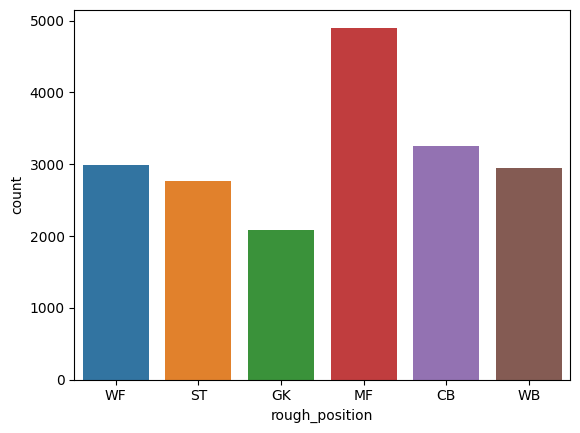

In [3]:
# Bar chart to display the distribution of players over the different positions
sns.countplot(x='rough_position', data = df)

The dataset contains detailed player characteristics with a score from 1 to 99 in each, and six summary statistics named Shooting, Passing, Defending, Physical, Dribbling, Pace. Each of these 6 summary statistics captures the combined impact of more detailed characteristics for that area (e.g. Shooting captures the overall score of characteristics such as finishing, volleys, heading accuracy, etc.).

As mentioned above, one problem is that the data for defending_marking is missing for all players. We can impute this value for each outfield player (any player whose position is not goalkeeper) starting from the overall Defending score and the scores available for the other defending skills.

For each outfield player I impute the value of defending_marking based on the following formula (taken from an example on Kaggle):

Marking = 10\*defending - 3\*defending_standing_tackle - 2\*mentality_interceptions - defending_sliding_tackle - attacking_heading_accuracy



In [4]:
# define function to impute the marking score
def impute_marking(row):
    return int((10*row['defending']-3*row['defending_standing_tackle']-2*row['mentality_interceptions']
                -row['attacking_heading_accuracy']-row['defending_sliding_tackle'])/3) if row['player_positions']!='GK' else np.nan

# apply function to each player
df['defending_marking']=df.apply(impute_marking, axis=1)

# check the summary statistics of the new variable
df['defending_marking'].describe() # the range makes sense: min = 8, max = 94

count    16860.000000
mean        50.253855
std         17.577195
min          8.000000
25%         36.000000
50%         55.000000
75%         64.000000
max         94.000000
Name: defending_marking, dtype: float64

**3. Exploratory data analysis**

We are going to use the dataset to assess what variables can predict the position of a player, and later use the players' scores in individual skills to predict their overall score and market value. In this dataset there is a clear difference between goalkeepers and outfield players, since these two groups of players have two different sets of skills. Goalkeepers are rated in skills such as handling, reflexes, etc, while outfield players are rated in skills such as passing, shooting, dribbling, etc. Therefore in this analysis I will focus exclusively on outfield players, who can play in a variety of different positions but are still rated on a common set of skills.

In [5]:
# Create a filter to exclude the goalkeepers from the dataset
outfield= df['rough_position'] != 'GK'

# Apply the filter to the dataset
df = df[outfield]

Let's check the dataset for the presence of outliers. Let's start with the physical characteristics of each player: height and weight.

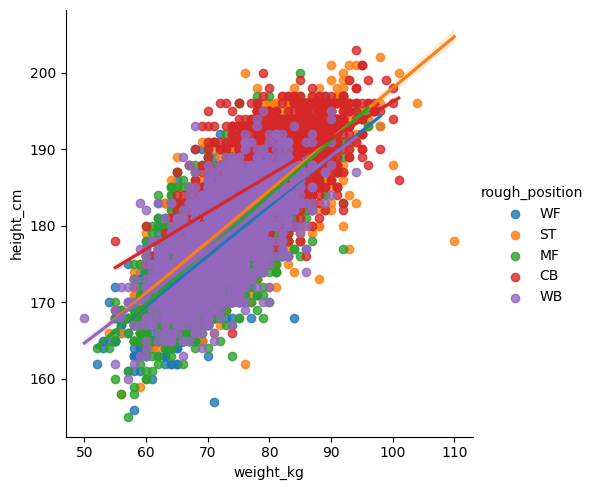

In [6]:
# Scatter plot of weight and height
sns.lmplot(x = 'weight_kg', y = 'height_cm', hue = 'rough_position', data = df)


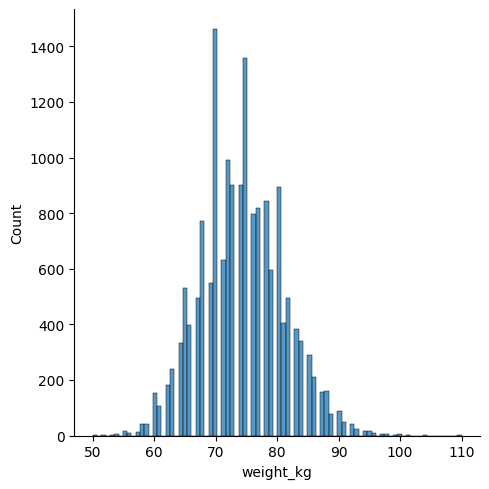

In [10]:
# Check distribution of weights
sns.displot(df['weight_kg'])

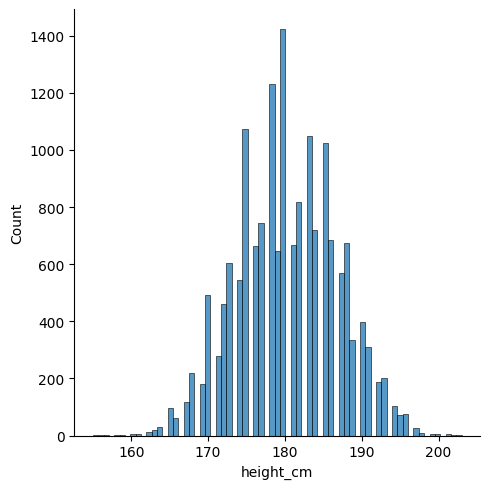

In [11]:
# Check distribution of heights
sns.displot(df['height_cm'])

We can check the distribution of weights and heights also with some box plots. Here we can see that there are some outliers in both variables (note that obviously the two variables have different units of measure, kg vs cm).

<Axes: >

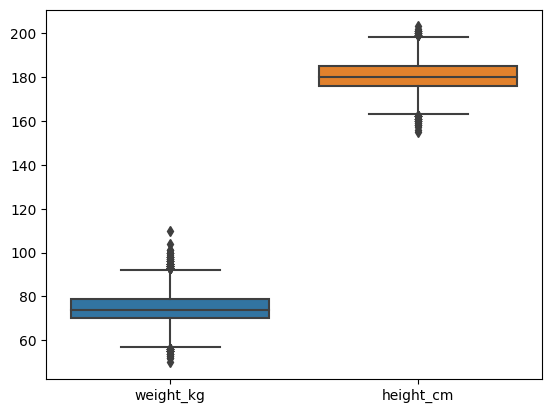

In [12]:
# Produce box plots for weight and height
sns.boxplot(data = df[['weight_kg', 'height_cm']])

Then we check for outliers in the distribution of the 6 summary scores. It appears that there are some outliers for passing, dribbling, physical and pace, but not for defending and shooting.

<Axes: >

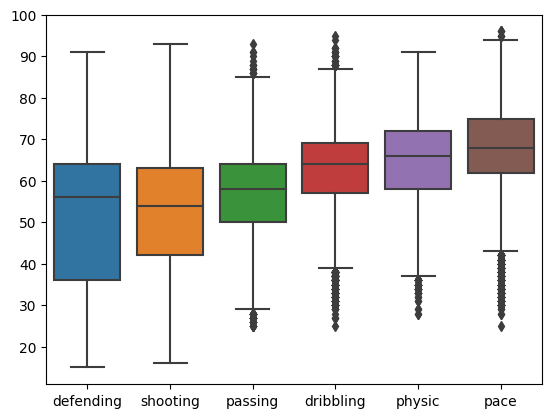

In [13]:
# Produce box plots for the 6 key skills
sns.boxplot(data = df[['defending', 'shooting', 'passing', 'dribbling', 'physic', 'pace']])

There are some outliers in passing, dribbling, physical and pace. Let's remove them by using Tukey's law, which is the same applied in Seaborn's box plots to identify the outliers.

The law says that to identify the outliers we have to calculate the inter-quartile range (IQR), which is the difference between third and first quartiles (Q3 and Q1), and then multiply this value by 1.5. All datapoints that lie below Q1 - 1.5\*IQR or above Q3 + 1.5\*IQR are considered outliers.

In [14]:
# Calculate inter-quartile range for passing
Q1_passing = df['passing'].quantile(0.25)
Q3_passing = df['passing'].quantile(0.75)
IQR_passing = Q3_passing - Q1_passing

# Identify non-outliers in passing
filter_passing = (df['passing'] >= Q1_passing - 1.5 * IQR_passing) & (df['passing'] <= Q3_passing + 1.5 *IQR_passing)

In [15]:
# Calculate inter-quartile range for dribbling
Q1_dribbling = df['dribbling'].quantile(0.25)
Q3_dribbling = df['dribbling'].quantile(0.75)
IQR_dribbling = Q3_dribbling - Q1_dribbling

# Identify non-outliers in dribbling
filter_dribbling = (df['dribbling'] >= Q1_dribbling - 1.5 * IQR_dribbling) & (df['dribbling'] <= Q3_dribbling + 1.5 *IQR_dribbling)

In [16]:
# Calculate inter-quartile range for physical
Q1_physic = df['physic'].quantile(0.25)
Q3_physic = df['physic'].quantile(0.75)
IQR_physic = Q3_physic - Q1_physic

# Identify non-outliers in physical
filter_physic = (df['physic'] >= Q1_physic - 1.5 * IQR_physic) & (df['physic'] <= Q3_physic + 1.5 *IQR_physic)

In [17]:
# Calculate inter-quartile range for pace
Q1_pace = df['pace'].quantile(0.25)
Q3_pace = df['pace'].quantile(0.75)
IQR_pace = Q3_pace - Q1_pace

# Identify non-outliers in pace
filter_pace = (df['pace'] >= Q1_pace - 1.5 * IQR_pace) & (df['pace'] <= Q3_pace + 1.5 *IQR_pace)

Now we can filter out all the outliers from the main dataframe.

<Axes: >

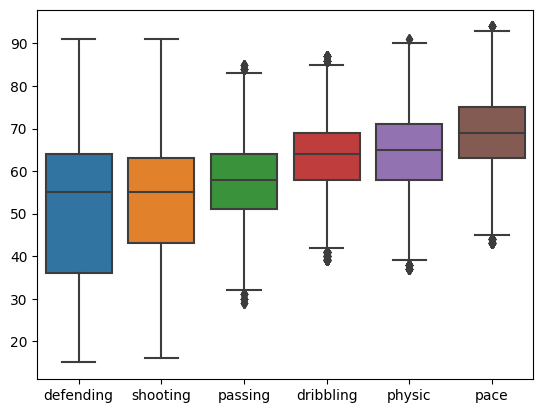

In [18]:
# create a new filter that captures all of the above
filter = (filter_passing & filter_dribbling & filter_physic & filter_pace)

# create a new dataframe without outliers
df_clean = df[filter]

# check the distribution of skills in the new dataframe
sns.boxplot(data = df_clean[['defending', 'shooting', 'passing', 'dribbling', 'physic', 'pace']])

There are still some outliers displayed in the box plot, but these are now much closer to the rest of the distribution.

We can plot also some violin plots to see how the distributions of weight and height change depending on the player position. From the violin plots below we can see that strikers and centre backs are on average taller and heavier than other types of players. The distribution of weight and height for centre backs also tends to be slightly more concentrated around the median compared to those of other players.

<Axes: xlabel='rough_position', ylabel='weight_kg'>

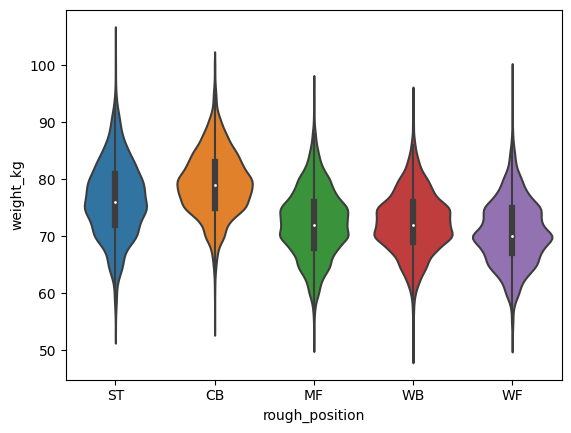

In [19]:
# Produce violin plots of weight for different positions
sns.violinplot(x = 'rough_position', y = 'weight_kg', data = df_clean)

<Axes: xlabel='rough_position', ylabel='height_cm'>

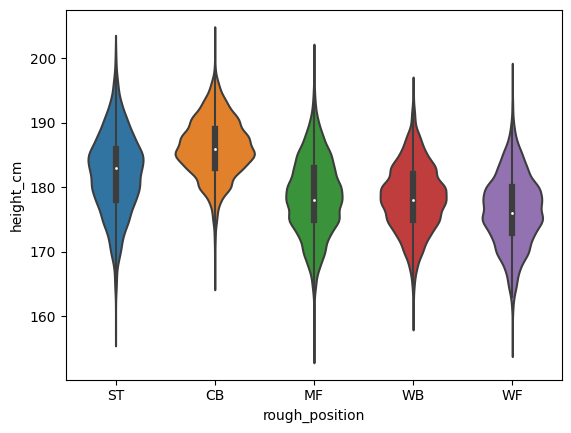

In [20]:
# Produce violin plots of height for different positions
sns.violinplot(x = 'rough_position', y = 'height_cm', data = df_clean)

**4. Data modelling and visualisations**

**4.1 Classification tasks**

As a first step, I explore different classification algorithms to predict a player's position based on the scores in the 6 key skills: shooting, passing, dribbling, defending, physical and pace.

I use first the K-Nearest-Neighbours algorithm and then the logistic regression model, and provide also some visualisations of the data and tests of the accuracy of the models.

**K-Nearest-Neighbours algorithm**

As a first task, I will use the K-Nearest-Neighbours algorithm to predict a player's role based on the scores of his skills.

Let's start with a simple example with just Central defenders and Strikers which, intuitively, should be easier to distinguish compared to other positions.

Here we use the KNN algorithm with K = 5.

In [21]:
# Define filters to keep only strikers and centre backs
strikers = df_clean['rough_position'] == 'ST'
defenders = df_clean['rough_position'] == 'CB'

# Apply filters to the dataset
knn_simple_data = df_clean[strikers | defenders]

# Check the size of the two groups
knn_simple_data.groupby('rough_position').size()

rough_position
CB    2596
ST    2700
dtype: int64

In [27]:
# Define feature and target data for the classification
knn_feature_data = knn_simple_data[['shooting', 'passing', 'dribbling', 'defending', 'pace', 'physic']]
knn_target_data = knn_simple_data[['rough_position']]

X = knn_feature_data
y = knn_target_data

# Reshape the y vector to feed into the knn module below
y = y.values.reshape(y.shape[0],)

In [28]:
# Import the KNN module
from sklearn.neighbors import KNeighborsClassifier

# Define the model with K = 5
knn5 = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn5.fit(X, y)

KNeighborsClassifier()

Now let's see how a new datapoint gets classfied by the KNN algorithm. Let's try two new datapoints with different sets of attributes. One has better 'attacking' scores (e.g. shooting and dribbling) and the other has better 'defending' scores (e.g. defending and physical).

Datapoint1: (85, 65, 80, 55, 75, 75)

Datapoint2: (60, 70, 70, 85, 75, 80)

In [29]:
# Predict datapoint 1
knn5.predict([[85, 75, 80, 55, 75, 75]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['ST'], dtype=object)

In [30]:
# Predict datapoint 2
knn5.predict([[60, 70, 70, 85, 75, 80]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['CB'], dtype=object)

**KNN visualisations**

Let's explore some visualisations to see whether the data for strikers and centre backs shows some significant differences between the two groups of players. With a simple scatter plot we can see that the two players form very distinct groups when we plot defending and shooting on the axes. As we would expect, centre backs have higher scores in defending while strkers have higher scores in shooting, and there is almost no overlap between the two groups.

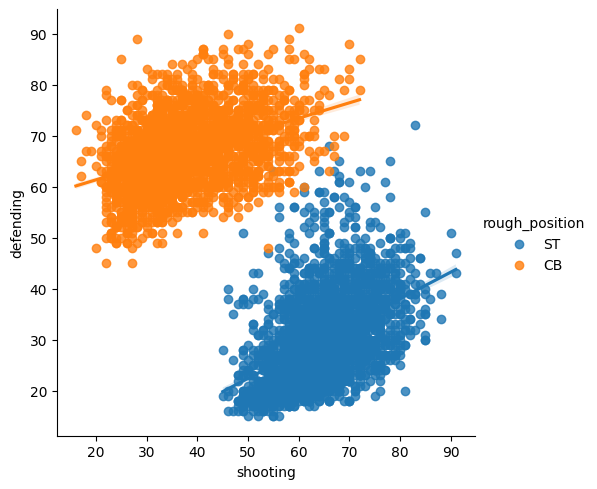

In [31]:
# Scatter plot of the key skills for strikers and defenders (shooting and defending)
sns.lmplot(x = 'shooting', y = 'defending', hue = 'rough_position', data = knn_simple_data)

We can inspect the data by producing some box plots. The box plots below show that for many skills there is not a very clear separation between strikers and centre backs. The medians and the interquartile ranges are often markedly different (in all skills except for passing), but the distributions are quite dispersed and the confidence intervals overlap in many cases. Only for the skill of defending we can see that the two group of players are very clearly separated, although there are still some outliers among the strikers who have a very high defending score.

<Figure size 640x480 with 0 Axes>

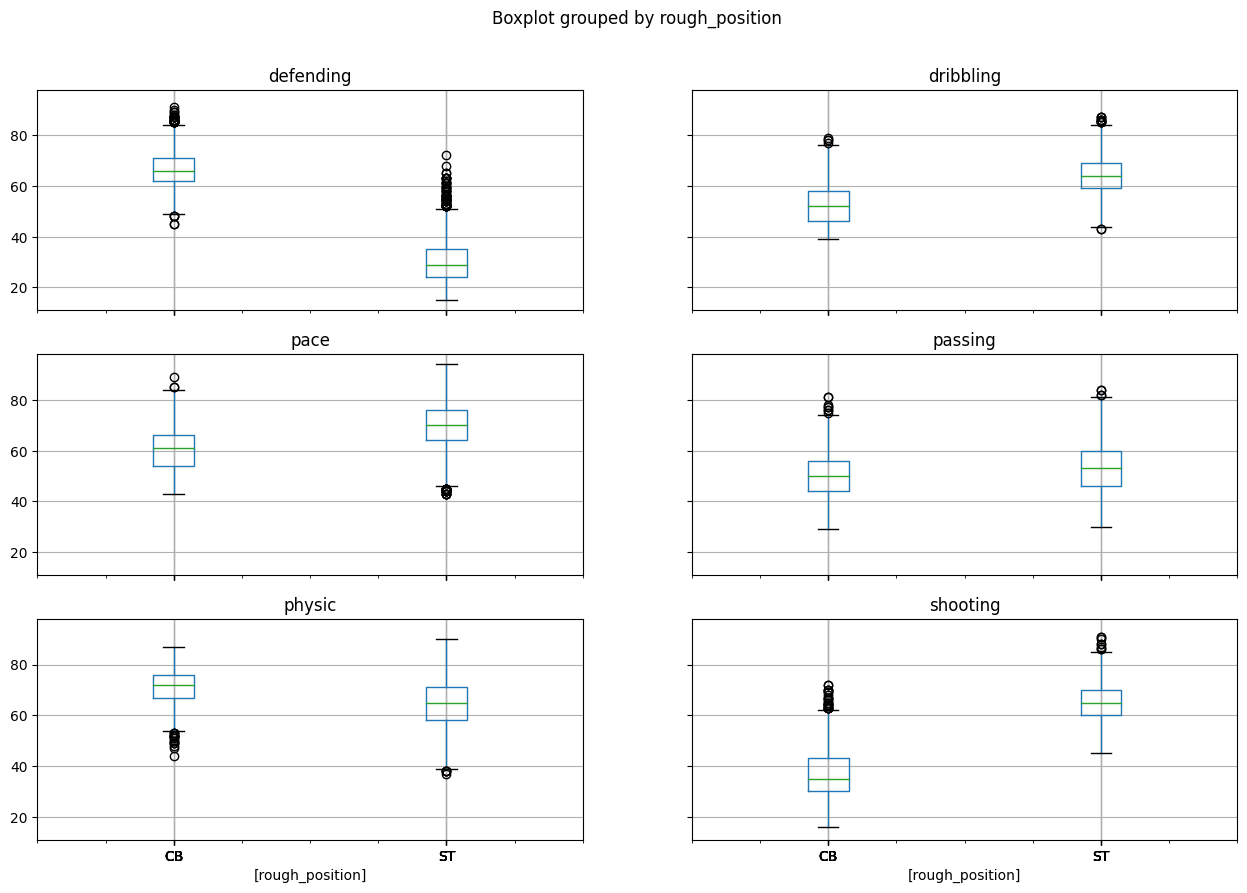

In [32]:
# Create a subset of the data with just the key skills and the players' positions
subset_data = knn_simple_data[['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace', 'rough_position']]

# Plot a series of box plots for the 6 skills
plt.figure()
subset_data.boxplot(by = 'rough_position', figsize = (15, 10))
plt.show()

We can explore some additional visualisation such as pairwise distributions. Here we can see very clearly that the distributions of scores for strikers and centre backs have substantial overlaps for most skills, and in some cases overlap almost perfectly (e.g. for passing). The only skill where the distributions are more clearly separated is defending, where obviously the distribution for centre backs covers much higher scores.

<Figure size 640x480 with 0 Axes>

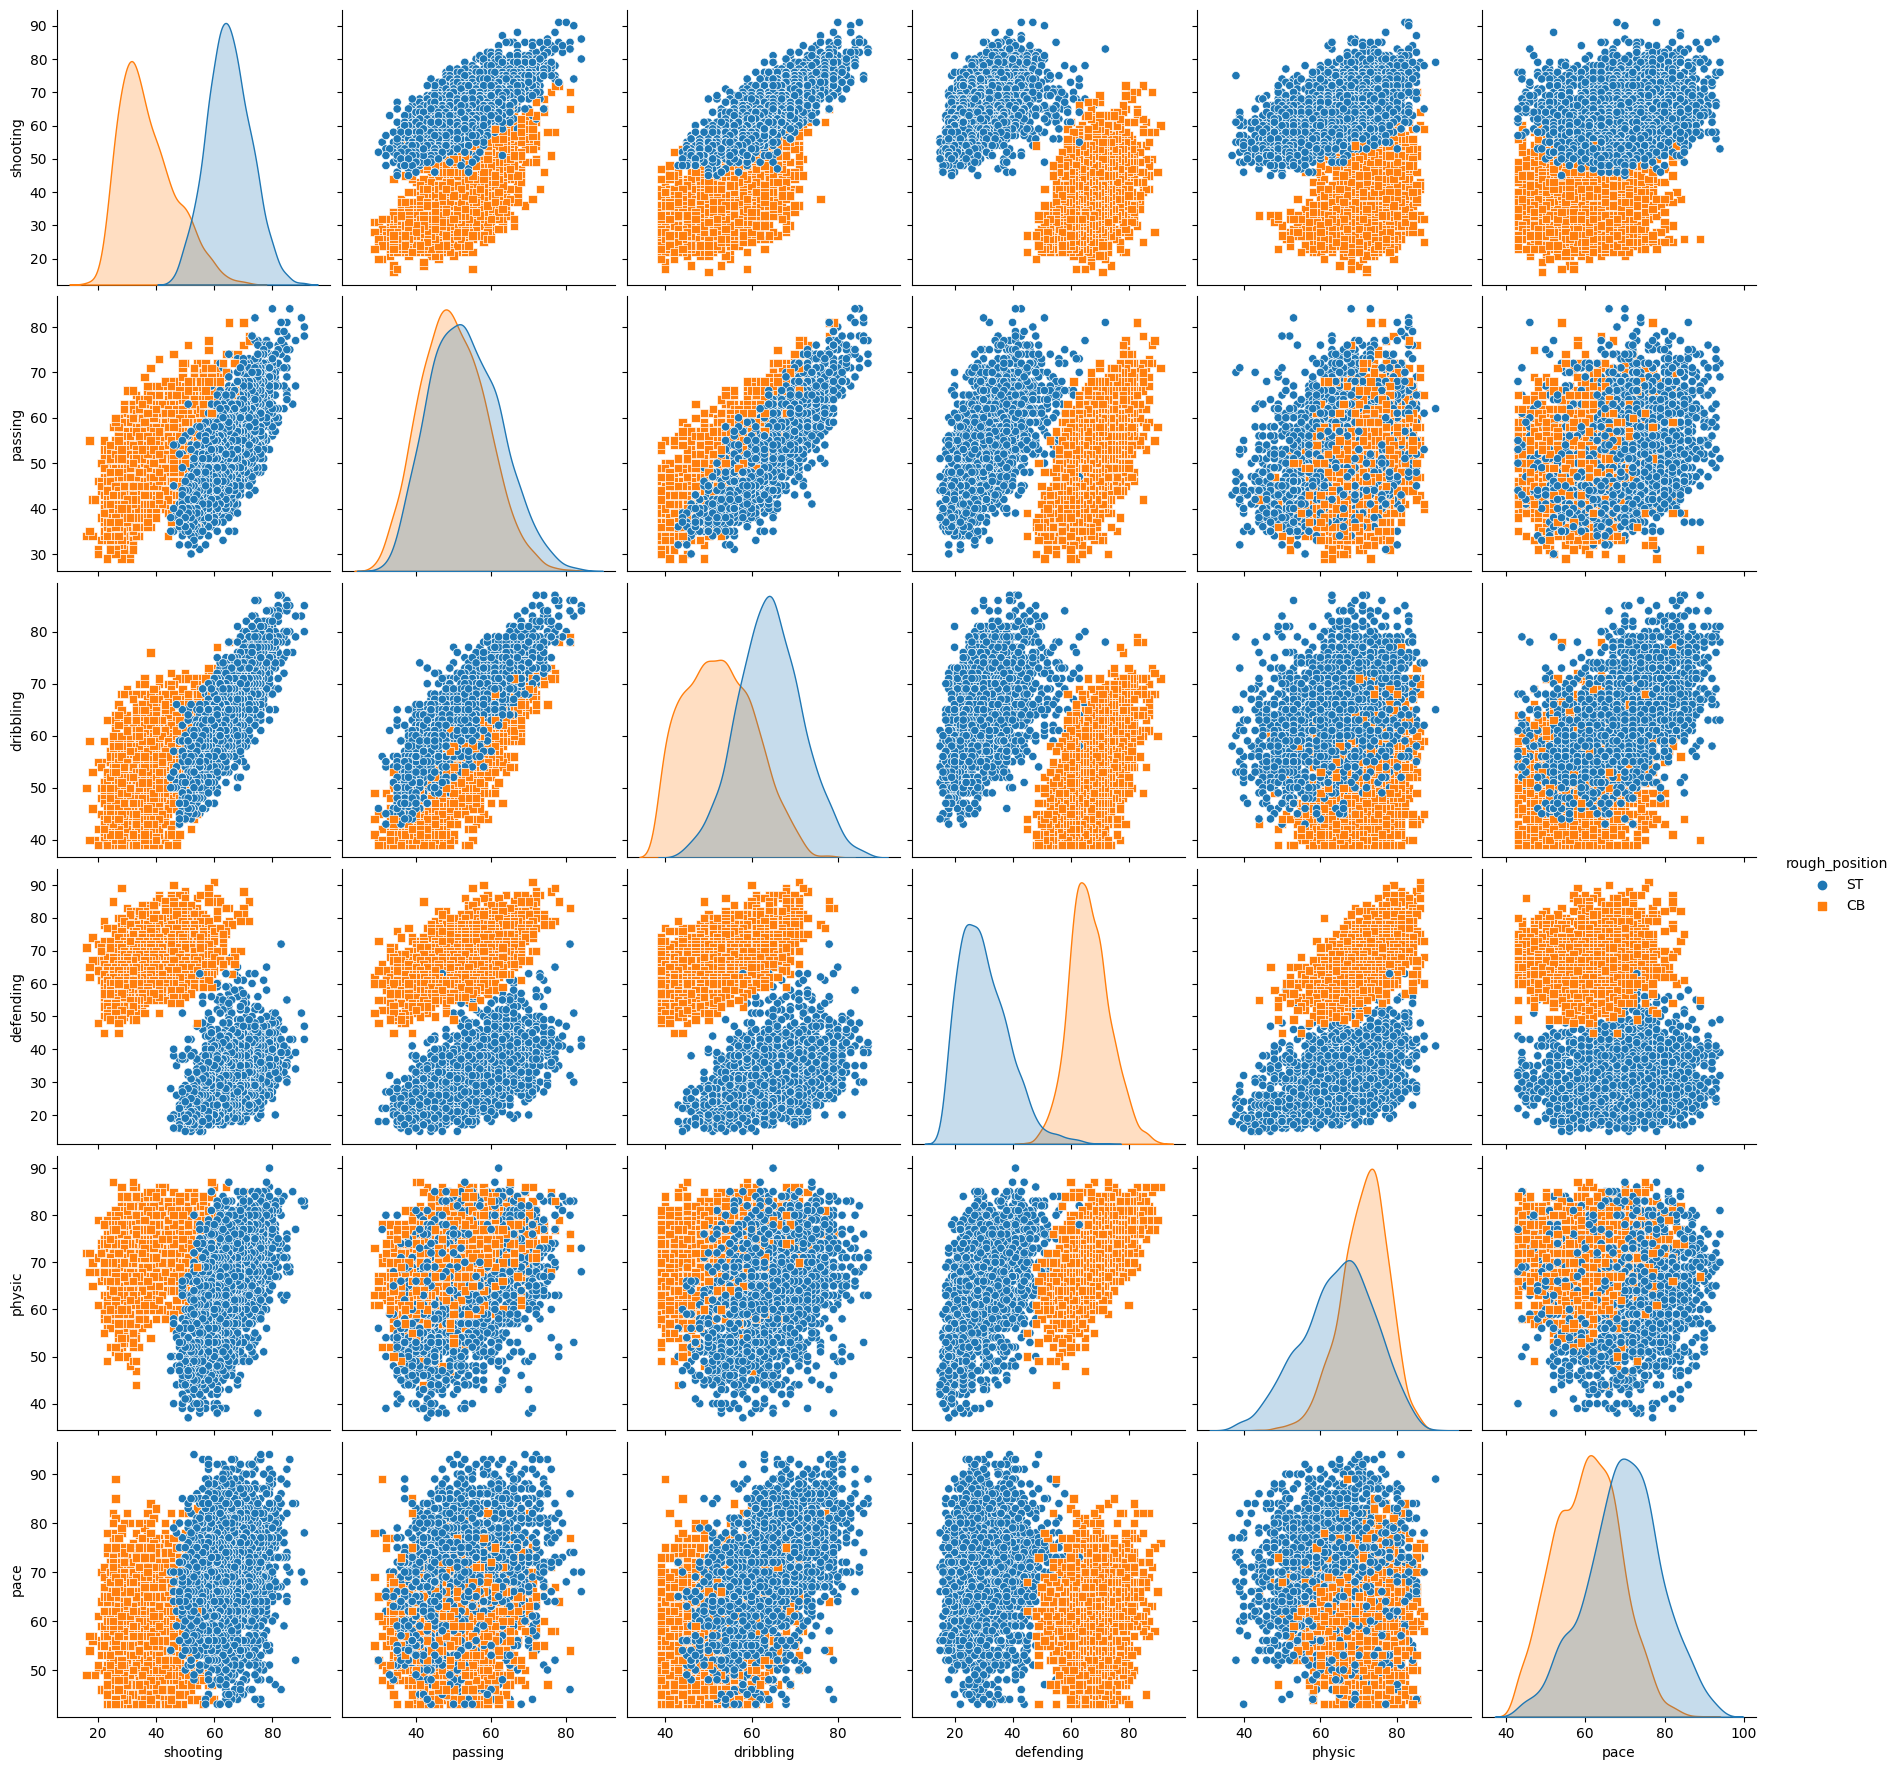

In [33]:
# Plot pairwise plots for the 6 skills for strikers and centre backs
plt.figure()
sns.pairplot(subset_data, hue = 'rough_position', height = 3, markers = ['o', 's'])
plt.show()

**KNN extended to all groups of players**

We can replicate the analysis above also for the entire dataset that includes players in all outfield positions. We still exclude goalkeepers because they have NaN scores for the skills that are common to other players.

In [34]:
# Define new feature and target data from the dataframe including all positions
knn_feature_data = df_clean[['shooting', 'passing', 'dribbling', 'defending', 'pace', 'physic']]
knn_target_data = df_clean[['rough_position']]

X = knn_feature_data
y = knn_target_data


# Reshape the y vector to feed into the knn module below
y = y.values.reshape(y.shape[0],)

Here we can also try the KNN algorithm with different numbers of neighbours. I pick 5, 25 and 50.

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model with different K numbers
knn5 = KNeighborsClassifier(n_neighbors=5)
knn25 = KNeighborsClassifier(n_neighbors=25)
knn50 = KNeighborsClassifier(n_neighbors=50)

# Fit the models
knn5.fit(X, y)
knn25.fit(X, y)
knn50.fit(X, y)

KNeighborsClassifier(n_neighbors=50)

Now we can see that, with a wider set of players and positions, the predictions of the algorithm can change slightly. Datapoint 1 now is predicted to be a wide forward, while datapoint 2 is still a centre back.

In [36]:
# Predict datapoint 1 with K = 5
knn5.predict([[85, 75, 80, 55, 75, 75]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['WF'], dtype=object)

In [37]:
# Predict datapoint 2 with K = 5
knn5.predict([[60, 70, 70, 85, 75, 80]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['CB'], dtype=object)

Now we can try the predictions also with K = 25 and K = 50 and see if they change.

Datapoint 1 is still predicted as a wide forward with K = 25 and K = 50.

In [38]:
# Predict datapoint 1 with K = 25
knn25.predict([[85, 75, 80, 55, 75, 75]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['WF'], dtype=object)

In [39]:
# Predict datapoint 1 with K = 50
knn50.predict([[85, 75, 80, 55, 75, 75]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['WF'], dtype=object)

Datapoint 2 switches from centre back to midfielder when N goes from 5 to 25, and stays as a midfielder even with N = 50.

In [40]:
# Predict datapoint 2 with K = 25
knn25.predict([[60, 70, 70, 85, 75, 80]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['MF'], dtype=object)

In [41]:
# Predict datapoint 2 with K = 50
knn50.predict([[60, 70, 70, 85, 75, 80]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['MF'], dtype=object)

**KNN: Assessing the accuracy of predictions: training and testing sets**

To assess the accuracy of the predictions of the KNN algorithm we have to split our dataset into a training set and a testing set.

In [42]:
# Import the module for train-test split
from sklearn.model_selection import train_test_split

# Define the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=3)

We have divided the dataset into 70% of observations used to train the algorithm, and 30% used to test it. More precisely, we have more 11,000 players in the training dataset and almost 5,000 in the testing dataset, as shown below. Now we can use the testing set to assess the accuracy of the predicitions.

In [43]:
# Check the dimensions of the subsets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11162, 6)
(4784, 6)
(11162,)
(4784,)


Here we run the KNN algorithm on the training set:

In [44]:
# Define the KNN models with different N numbers
knn5 = KNeighborsClassifier(n_neighbors=5)
knn25 = KNeighborsClassifier(n_neighbors=25)
knn50 = KNeighborsClassifier(n_neighbors=50)

# Fit the models
knn5.fit(X_train, y_train)
knn25.fit(X_train, y_train)
knn50.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

And we test the predictions on the testing set:

In [45]:
# Import module to calculate predictions accuracy
from sklearn import metrics

# Define the sets of predictions from the KNN models
y_pred5 = knn5.predict(X_test)
y_pred25 = knn25.predict(X_test)
y_pred50 = knn50.predict(X_test)

# Print the accuracy of each model
print('Accuracy with K=5: ', metrics.accuracy_score(y_test, y_pred5))
print('Accuracy with K=25: ', metrics.accuracy_score(y_test, y_pred25))
print('Accuracy with K=50: ', metrics.accuracy_score(y_test, y_pred50))

Accuracy with K=5:  0.75
Accuracy with K=25:  0.7725752508361204
Accuracy with K=50:  0.7713210702341137


**KNN: Finding the best K**

Here I create a loop to run the KNN algorithm with several different values of K and then plot the accuracy scores obtained with each K, in order to identify the K that maximises prediction accuracy.

In [46]:
# Define a range of K from 1 to 100
k_range = range(1, 100)

# Initiate an empty list for accuracy scores
scores = []

# Loop: calculate accuracy for each K and append them in the list
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, np.ravel(y_train))
  y_pred = knn.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, y_pred)
  scores.append(accuracy)


Text(0, 0.5, 'Accuracy of predictions')

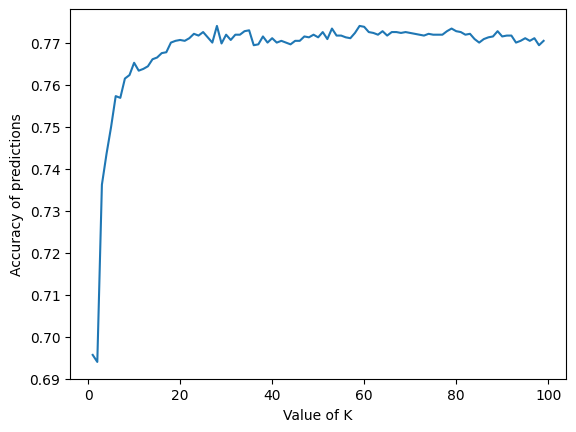

In [47]:
# Plot the accuracy score for different K numbers
plt.plot(k_range, scores)
plt.xlabel('Value of K')
plt.ylabel('Accuracy of predictions')

It appears that the KNN algorithm reaches a maximum level of precision of around 77% for K above 20. Once this level is achieved, the accuracy does not improve if K gets larger, and keeps oscillating around the 77% level.

**Logistic regression**

Let's try the same classification exercise by using a logistic regression instead of a KNN algorithm.

In [54]:
# Define feature and target data for the logistic regression
log_feature_data = df_clean[['shooting', 'passing', 'dribbling', 'defending', 'pace', 'physic']]
log_target_data = df_clean[['rough_position']]

X = log_feature_data
y = log_target_data

# Reshape the y vector to feed into the knn module below
y = y.values.reshape(y.shape[0],)

In [56]:
# Import the module for logistic regression
from sklearn.linear_model import LogisticRegression

# Define the model
logreg = LogisticRegression(max_iter = 10000)

# Fit the model
logreg.fit(X, y)

LogisticRegression(max_iter=10000)

Let's check if the predictions for datapoints 1 and 2 from above have changed.

In [57]:
# Predict datapoint 1 with logistic regression
logreg.predict([[85, 75, 80, 55, 75, 75]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array(['ST'], dtype=object)

In [51]:
# Predict datapoint 2 with logistic regression
logreg.predict([[60, 70, 70, 85, 75, 80]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array(['CB'], dtype=object)

Datapoint 2 is still predicted as a centre back, but datapoint 1 is now predicted as a striker.

**Logistic regresison: Assessing the accuracy of predictions: training and testing sets**

Let's assess the accuracy of the predictions by using training and testing sets, as shown above for KNN.

In [58]:
# Define training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=3)

# Check dimensions of the sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11162, 6)
(4784, 6)
(11162,)
(4784,)


In [59]:
# Define and fit the model
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)

# Create predictions
y_pred = logreg.predict(X_test)

In [60]:
# Print accuracy of the logistic regression
print('Accuracy of the logistic regression: ', metrics.accuracy_score(y_test, y_pred))

Accuracy of the logistic regression:  0.7709030100334449


**4.2 Regression analysis**

**Linear regression**

As a second task, I will use linear regression to predict the market value of a player based on the scores in the 6 key skills: shooting, passing, dribbling, defending, physical, pace.

First, let's inspect some plots to assess whether there appears to be a strong relationship between the market value of players and each of their main skills (shooting, passing, dribbling, defending, physical and pace).

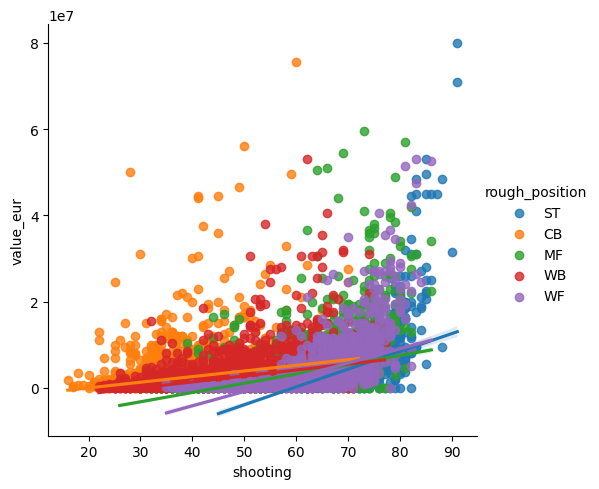

In [61]:
# Scatter plot of shooting scores and market value of players, for different positions
sns.lmplot(x = 'shooting', y = 'value_eur', hue = 'rough_position', data = df_clean)

We can see that the relationship between shooting and market value is almost non-existent for centre backs (the fit line is almost horizontal), while the relationship appears much stronger for strikers, as we would expect, and also for wide forwards. We can observe something similar also for other skills. For example, defending has a strong relationship with market value for centre backs and wide backs but, predictably, not so much for strikers.

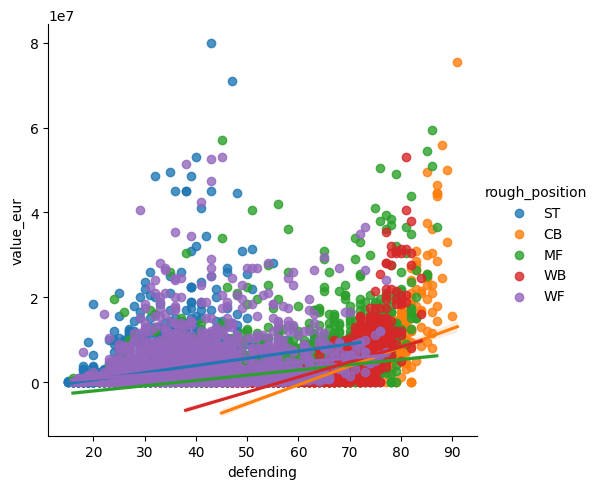

In [62]:
# Scatter plot of defending and market value of players, for different positions
sns.lmplot(x = 'defending', y = 'value_eur', hue = 'rough_position', data = df_clean)

Now let's try to use linear regression to predict a player's value based on his main skills (shooting, passing, dribbling, defending, physical and pace) and on his position.

In [63]:
# Define feature and target data for the linear regression
reg_feature_data = df_clean[['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace']]
reg_target_data = df_clean[['value_eur']]

X = reg_feature_data
y = reg_target_data

In [64]:
# Import the linear regression moduls
from sklearn.linear_model import LinearRegression

# Define the model
linreg = LinearRegression()

# Fit the model
linreg.fit(X, y)

LinearRegression()

Let's see how well the regression can predict the market value of players. Let's extract the data for some of the players and see what the linear regression model predicts for them.

In [65]:
# Extract the feature data for observation number 3500
reg_feature_data.loc[3500]

shooting     55.0
passing      70.0
dribbling    64.0
defending    66.0
physic       81.0
pace         67.0
Name: 3500, dtype: float64

In [66]:
# Extract the target data (market value) for observation number 3500
reg_target_data.loc[3500]

value_eur    2400000
Name: 3500, dtype: int64

In [67]:
# Predict the market value for this observation with the linear regression model
linreg.predict([[55, 70, 64, 66, 81, 67]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[4707735.83330545]])

The prediction is quite far from the true value, so apparently the linear regression model is not working very well at predicting players' market value.

**Linear regression: controlling for players' positions**

However, the charts produced earlier show that some skills have a stronger impact on market value for certain categories of players but not for others. Therefore, if we want to use linear regression to predict market value based on skills, we have to include in the regression also variables that control for the position of a player.

We do this by introducing binary variables (dummies) that can be equal to 1 or 0 for each of the main positions (CB, WB, MF, WF and ST). For example, a striker will have value 1 in the ST dummy, and value 0 in all other dummies.

Let's define the dummies.

In [68]:
# Define the dummies with the get_dummies module
dummies = pd.get_dummies(df_clean.rough_position, prefix='dummy')

# Inspect the dummies
dummies.head()

,dummy_CB,dummy_MF,dummy_ST,dummy_WB,dummy_WF
3,0,0,1,0,0
8,1,0,0,0,0
14,1,0,0,0,0
15,0,0,1,0,0
17,0,1,0,0,0


Now we need to combine the dummies with our main dataset. I do this with the concatenate function from pandas.

In [69]:
# Create a new version of the dataset that includes also the dummies
df_dummy = pd.concat([df_clean, dummies], axis = 1)

# Inspect the dataset
df_dummy.head()

,sofifa_id,short_name,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,...,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,rough_position,dummy_CB,dummy_MF,dummy_ST,dummy_WB,dummy_WF
3,188545,R. Lewandowski,31,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,...,6,12,8,10,ST,0,0,1,0,0
8,203376,V. van Dijk,28,193,92,Netherlands,Liverpool,English Premier League,1.0,90,...,10,13,11,11,CB,1,0,0,0,0
14,155862,Sergio Ramos,34,184,82,Spain,Real Madrid,Spain Primera Division,1.0,89,...,8,9,7,11,CB,1,0,0,0,0
15,165153,K. Benzema,32,185,81,France,Real Madrid,Spain Primera Division,1.0,89,...,11,5,5,7,ST,0,0,1,0,0
17,200145,Casemiro,28,185,84,Brazil,Real Madrid,Spain Primera Division,1.0,89,...,14,16,12,12,MF,0,1,0,0,0


Now we can use linear regression to predict a player's value based on his main skills (shooting, passing, dribbling, defending, physical and pace) and on his position.

In [70]:
# Define feature and target data from the updated dataset
reg_feature_data = df_dummy[['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace', 'dummy_CB', 'dummy_WB', 'dummy_MF', 'dummy_WF', 'dummy_ST']]
reg_target_data = df_dummy[['value_eur']]

X = reg_feature_data
y = reg_target_data


In [71]:
# Define a new regression model
linreg2 = LinearRegression()

# Fit the model
linreg2.fit(X, y)

LinearRegression()

Let's try again to predict the market value for the same player.

In [72]:
# Extract the feature data for observation number 3500
reg_feature_data.loc[3500]

shooting     55.0
passing      70.0
dribbling    64.0
defending    66.0
physic       81.0
pace         67.0
dummy_CB      0.0
dummy_WB      0.0
dummy_MF      1.0
dummy_WF      0.0
dummy_ST      0.0
Name: 3500, dtype: float64

In [73]:
# Extract the target data for observation number 3500
reg_target_data.loc[3500]

value_eur    2400000
Name: 3500, dtype: int64

In [ ]:
# Predict the market value with the linear regression model
linreg2.predict([[55, 70, 64, 66, 81, 67, 0, 0, 1, 0, 0]])

array([[3736137.50290851]])

The prediction got better and it is closer to the true value, but it is still quite imprecise.

**Linear regression: evaluating the accuracy of predictions**

Here I will calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) statistics to assess the accuracy of the regression model.

In [74]:
# Import new modules
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Create the predictions from the linear regression
y_predicted = linreg2.predict(X)

# Calculate the errors of the model
error = mean_squared_error(y, y_predicted)
root_error = math.sqrt(mean_squared_error(y, y_predicted))
mean_abs_error = mean_absolute_error(y, y_predicted)

# Display the errors
print('Mean Squared Error: ', error)
print('Root Mean Squared Error: ', root_error)
print('Mean Absolute Error: ', mean_abs_error)

Mean Squared Error:  13246169211507.027
Root Mean Squared Error:  3639528.7073338255
Mean Absolute Error:  2069643.1723351064


RMSE and MAE are quite different, so this means that the errors of the regression model are not all of the same magnitude.

**Linear regression: restricting the dataset to improve accuracy**

The reason for the low accuracy of the predictions this might be that the dataset still captures too much variation in the distribution of values, so that the datapoints are too dispersed around the linear regression line, and therefore predictions are not precise.

Let's have a look at the distribution of market values.

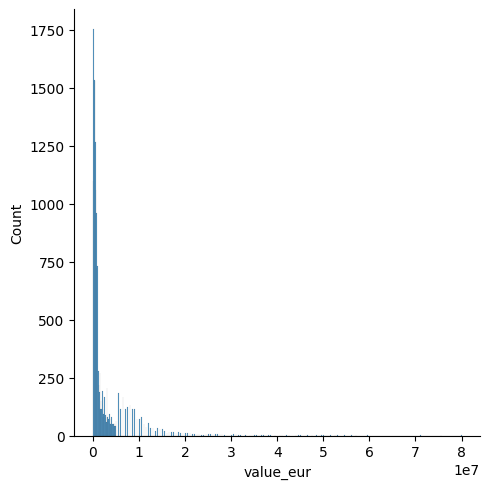

In [75]:
# Inspect the distribution of market values
sns.displot(df_dummy['value_eur'])

The distribution is very skewed, with many observations having very low values. Let's see what the median and quartiles are:

In [76]:
# Check the key statistics of market values
df_dummy['value_eur'].describe()

count    1.594600e+04
mean     2.249970e+06
std      4.556529e+06
min      0.000000e+00
25%      3.250000e+05
50%      7.000000e+05
75%      1.900000e+06
max      8.000000e+07
Name: value_eur, dtype: float64

Maybe the linear regression predictions would get better if we considered only the observations with market value closer to the median of the distribution. Let's try to restrict the dataset to observations that are within the interquartile range of market values and see if the predictions improve.

As shown above, the first quartile corresponds to a market value of 325,000 EUR and the third quartile corresponds to a market value of 1,900,000 EUR.

In [77]:
# Define filters to identify observations in the inter-quartile range
filter_value1 = df_dummy['value_eur'] > 325000
filter_value2 = df_dummy['value_eur'] < 1900000

# Apply filters to the dataset
df_new = df_dummy[filter_value1 & filter_value2]

# Inspect the statistics of the updated dataset
df_new.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,...,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,dummy_CB,dummy_MF,dummy_ST,dummy_WB,dummy_WF
count,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7.809000e+03,7809.00000,7809.000000,...,7809.000000,7809.000000,7809.000000,7809.00000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000
mean,228191.873863,24.979127,180.098860,73.945832,1.398771,65.532078,70.827123,7.840409e+05,3879.88859,1.019593,...,10.430145,10.493533,10.431041,10.42451,10.414138,0.166090,0.284287,0.165194,0.189269,0.195159
std,23186.986337,4.117722,6.365829,6.428099,0.722358,2.812084,4.379369,3.580397e+05,3985.12176,0.144043,...,3.290459,3.214296,3.350838,3.26721,3.205853,0.372186,0.451103,0.371379,0.391747,0.396349
min,3281.000000,16.000000,155.000000,50.000000,1.000000,59.000000,62.000000,3.500000e+05,500.00000,1.000000,...,3.000000,2.000000,1.000000,3.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,213368.000000,22.000000,175.000000,70.000000,1.000000,63.000000,68.000000,5.000000e+05,2000.00000,1.000000,...,8.000000,8.000000,8.000000,8.00000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,233397.000000,25.000000,180.000000,74.000000,1.000000,66.000000,70.000000,7.000000e+05,3000.00000,1.000000,...,10.000000,10.000000,10.000000,10.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,245159.000000,28.000000,185.000000,78.000000,2.000000,68.000000,74.000000,9.750000e+05,5000.00000,1.000000,...,13.000000,13.000000,13.000000,13.00000,13.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,258958.000000,39.000000,203.000000,100.000000,4.000000,76.000000,88.000000,1.800000e+06,50000.00000,3.000000,...,67.000000,75.000000,75.000000,66.00000,59.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's run the regression model again and let's try some new predictions.

In [78]:
# Define the feature and target data
reg_feature_data = df_new[['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace', 'dummy_CB', 'dummy_WB', 'dummy_MF', 'dummy_WF', 'dummy_ST']]
reg_target_data = df_new[['value_eur']]

X = reg_feature_data
y = reg_target_data

# Define the model
linreg3 = LinearRegression()

# Fit the model
linreg3.fit(X, y)


LinearRegression()

In [79]:
# Extract the feature data for observation number 5000
reg_feature_data.loc[5000]

shooting     64.0
passing      70.0
dribbling    71.0
defending    36.0
physic       60.0
pace         76.0
dummy_CB      0.0
dummy_WB      0.0
dummy_MF      0.0
dummy_WF      1.0
dummy_ST      0.0
Name: 5000, dtype: float64

In [80]:
# Extract the target data for observation number 5000
reg_target_data.loc[5000]

value_eur    1100000
Name: 5000, dtype: int64

In [81]:
# Predict the market value with the linear regression model
linreg3.predict([[64, 70, 71, 36, 60, 76, 0, 0, 0, 1, 0]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[1000791.09446589]])

The prediction is now much better and we get very close to the actual market value of the player.

Let's assess the accuracy of the model by calculating again the Mean Squared Error, Root Mean Squared Error and Mean Absolute Error statistics. Below we can see that the errors are much smaller when the regression model is run on the restricted sample.

In [82]:
# Create the predictions from the regression model
y_predicted = linreg3.predict(X)

# Calculate the errors of the model
error = mean_squared_error(y, y_predicted)
root_error = math.sqrt(mean_squared_error(y, y_predicted))
mean_abs_error = mean_absolute_error(y, y_predicted)

# Display the errors
print('Mean Squared Error: ', error)
print('Root Mean Squared Error: ', root_error)
print('Mean Absolute Error: ', mean_abs_error)

Mean Squared Error:  95613189994.76656
Root Mean Squared Error:  309213.825685021
Mean Absolute Error:  240399.9730030166


**Polynomial regression**

Here I check whether the predictions would improve if I used a polynomial regression instead of a linear regression model. First I define the polynomial model, where I use only polynomials of 2nd degree, to keep the model as simple as possible, while still allowing the model to better capture the variance in the data.

In [83]:
# Import the module for the polynomial regression
from sklearn.preprocessing import PolynomialFeatures

# Define the model
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Fit the model
poly.fit(X_poly, y)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression()

Let's see if the polynomial regression predicts a different value for the same observation used above with the linear regression.

In [84]:
# Extract the feature data for observation number 5000
reg_feature_data.loc[5000]

shooting     64.0
passing      70.0
dribbling    71.0
defending    36.0
physic       60.0
pace         76.0
dummy_CB      0.0
dummy_WB      0.0
dummy_MF      0.0
dummy_WF      1.0
dummy_ST      0.0
Name: 5000, dtype: float64

In [85]:
# Extract the target data for observation number 5000
reg_target_data.loc[5000]

value_eur    1100000
Name: 5000, dtype: int64

In [86]:
# Predict the market value with the ploynomial regression
pol_reg.predict(poly.fit_transform([[64, 70, 71, 36, 60, 76, 0, 0, 0, 1, 0]]))

array([[1391171.06988133]])

The polynomial regression predicts a value which is higher than the true one, while the linear regression had predicted a value which was slightly lower.

**Polynomial regression: assessing the accuracy of the model**

As above, I assess the accuracy of the model by calculating again the Mean Squared Error, Root Mean Squared Error and Mean Absolute Error statistics. Below we can see that the errors are much smaller when the regression model is run on the restricted sample.

In [87]:
# Create the predictions from the linear regression
y_predicted = pol_reg.predict(poly.fit_transform(X))

# Calculate the errors
error = mean_squared_error(y, y_predicted)
root_error = math.sqrt(mean_squared_error(y, y_predicted))
mean_abs_error = mean_absolute_error(y, y_predicted)

# Display the errors
print('Mean Squared Error: ', error)
print('Root Mean Squared Error: ', root_error)
print('Mean Absolute Error: ', mean_abs_error)

Mean Squared Error:  56564621723.69262
Root Mean Squared Error:  237833.18045153545
Mean Absolute Error:  178337.52076072866


The errors are lower than those for the linear regression model because the polynomial regression can better explain the variance of player values. The Root Mean Squared Error also gets closer to the Mean Absolute Error, meaning that the errors of the polynomial model have a more homogeneous magnitude compared to the errors of the linear regression model.

**4.3 Unsupervised learning: clustering**

As a last task in the analysis, I use the k-means clustering algorithm to identify subgroups of players based on their skill scores. First I import the relevant module and restrict the dataset to a smaller sample to make visualisations more clear.

In [88]:
# Importing Modules
from sklearn.cluster import KMeans

# Extract a subset of variables from the dataset
features = df_new[['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace']]

# Extract a random sample from the dataset (to reduce the number of observations to be visualised)
X = features.sample(200)

With the k-means algorithm we can split the dataset into a specified number of clusters. Here I split the data into 3 clusters, and show the clusters and their centroids in a 3D graph.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


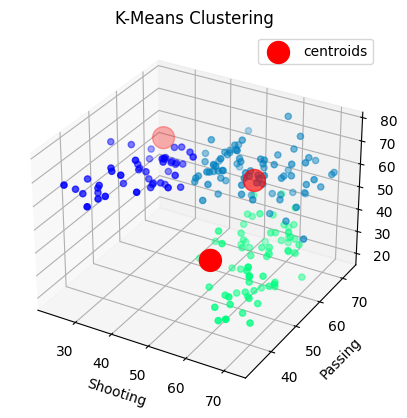

In [89]:
# Imports
from mpl_toolkits.mplot3d import Axes3D

# Instantiate Kmeans
km = KMeans(3)
clusts = km.fit_predict(X)

#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(km.cluster_centers_[:, 3],
            km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 2],
            s = 250,
            marker='o',
            c='red',
            label='centroids')
scatter = ax.scatter(X['shooting'],X['passing'], X['defending'],
                     c=clusts,s=20, cmap='winter')


ax.set_title('K-Means Clustering')
ax.set_xlabel('Shooting')
ax.set_ylabel('Passing')
ax.set_zlabel('Defending')
ax.legend()
plt.show()